# MAX-CUT for QAOA:
## Undirected Unweighted MAX-CUT:

### The toolkit provides predefined examples for users so that the entire process of QAOA can be conducted easily within 2 functions. In the first example, we will look at undirected and unweighted; for all edges $e, w_e = 1$. We just have to import the max_cut package from the predefined examples folder:

In [1]:
# import the predefined library
import os 
os.path.abspath(os.curdir)
os.path.sys.path.append('../predefined_problems/')

import max_cut as mc

### For MAX-CUT, we have to generate a graph, in this case a butterfly graph would suffice:

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


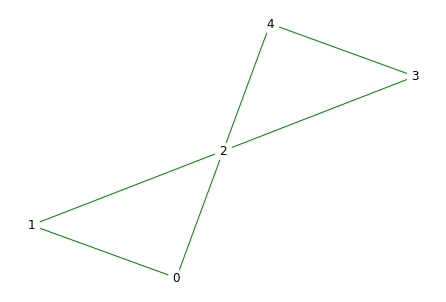

In [2]:
# Create a graph for the problem its is also adviseable to instantiate the weight of the graphs else it 
# be defaulted to 1
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

### The next step is to instantiate the max_cut object. For the max-cut problem; we defined the objective function $f(x)$ = $x_1 \oplus x_2$ = $\neg x_1 \wedge x_2$ | $\neg x_2 \wedge x_1$

In [3]:
# instantiate a MAX_CUT object which prepares converts the objective function into a pauli hamiltonian
max_cut = mc.max_cut(G)

### The user also have an option of generating the quantum circuit to view the circuit layout, Users also have to delcare hyperparameters:

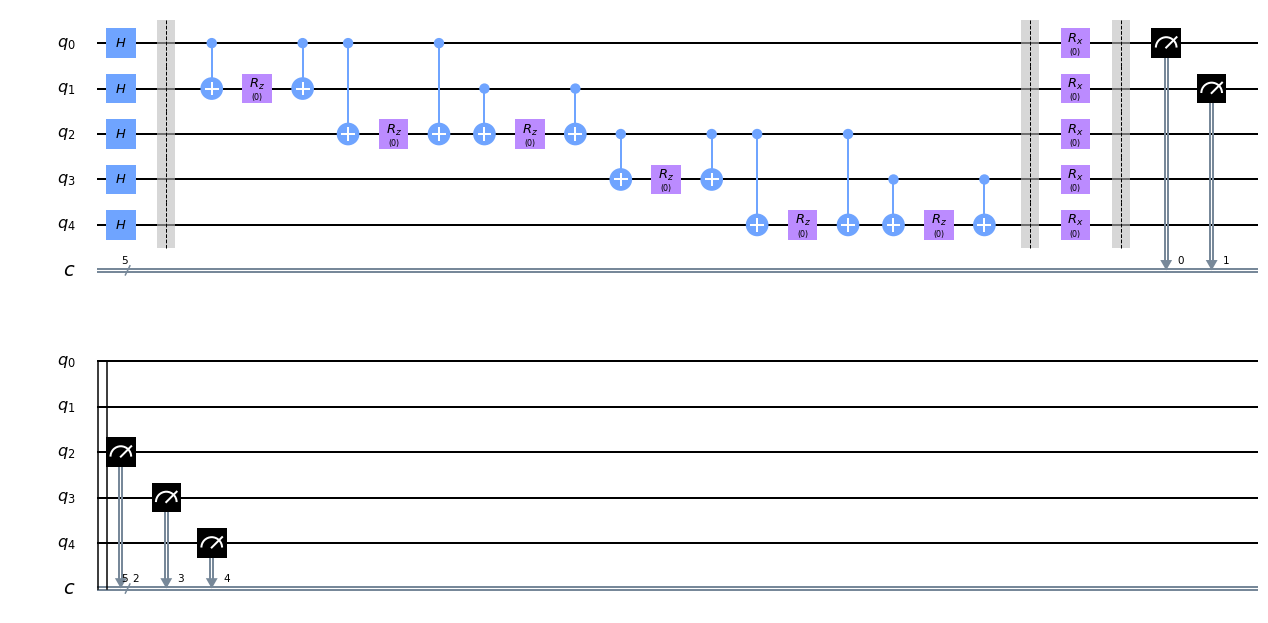

In [4]:
# Generate the circuit for graph per Edge mapping
hyperparams = [0.0,0.0]
max_cut.generate_quantumCircuit(G, hyperparams)

### After generation of the circuit, users can run the ciruit once to get the expectation values, this function was created so that users can run the circuit once after getting the optimal hyperparameters:

In [5]:
# run the circuit once 
results = max_cut.run_circuit(G)

backend setup: Complete running circuit
Simulation: Complete!
Expectation Value : 2.955078125


### User can call *run_QAOA()* function to run  the entire process of QAOA algorithm to obtain the highest expectation value of the problem graph. The function uses scipy.opt to optimize the hyperparameters, thus, users can choose their preferred optimizer:

In [6]:
hyperparams=[2.63851474, 0.68736767]
max_cut.run_QAOA(hyperparams,'COBYLA')

     fun: -3.9296875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 21
  status: 1
 success: True
       x: array([2.5223955, 0.6359044])


array([2.5223955, 0.6359044])

## Weighted Undirected MAX-CUT:

### The max_cut package also allows for weighted edges to included into the graph. The Objective function remains the same as the previous example. So we can use the same graph but this time with weights and repeat the same process:

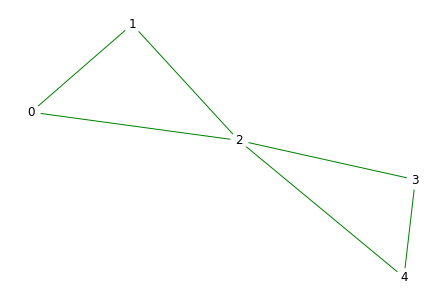

In [7]:
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,6.0),(0,2,7.0),(1,2,8.0),(3,2,9.0),(3,4,10.0),(4,2,4.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)


nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

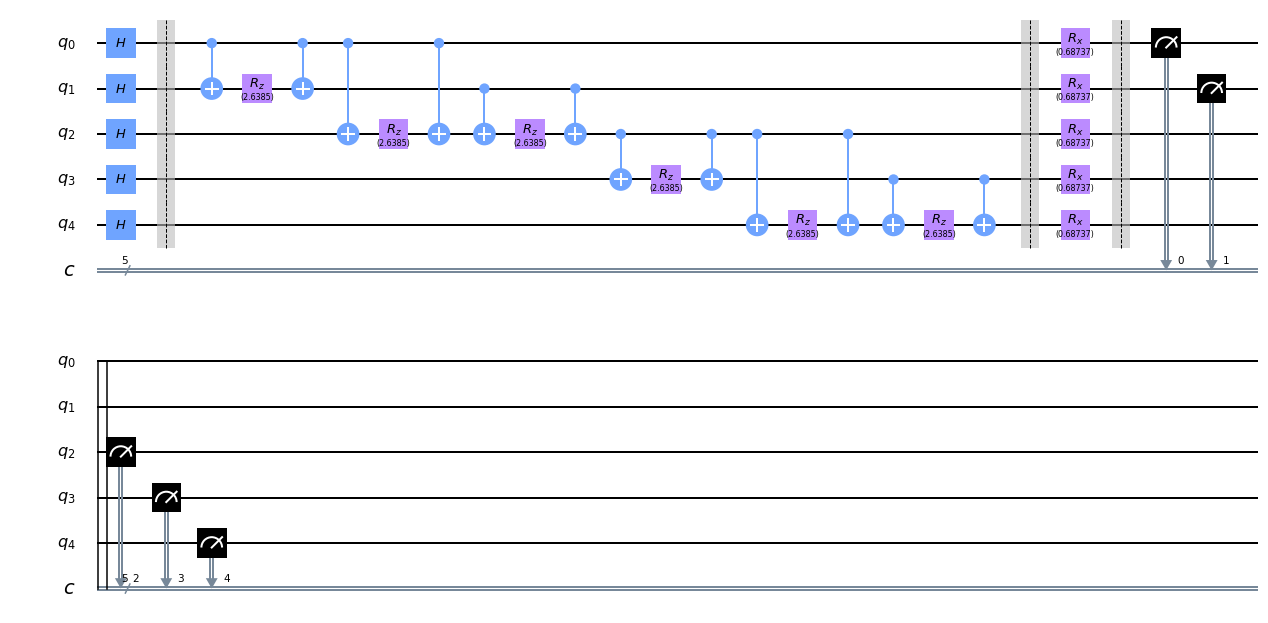

In [8]:
# instantiate a MAX_CUT object which prepares converts the objective function into a Pauli Hamiltonian
shots = 1024
max_cutWeights = mc.max_cut(G,shots=shots)
max_cutWeights.generate_quantumCircuit(G, hyperparams)

In [9]:
hyperparams=[2.52335949, 0.61918943]
opt_hyperparams = max_cutWeights.run_QAOA(hyperparams,'COBYLA')

     fun: -28.8642578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 23
  status: 1
 success: True
       x: array([2.57920336, 0.70075918])


In [10]:
max_cutWeights.generate_quantumCircuit(G, opt_hyperparams)
res = max_cutWeights.run_circuit(G)

backend setup: Complete running circuit
Simulation: Complete!
Expectation Value : 29.0


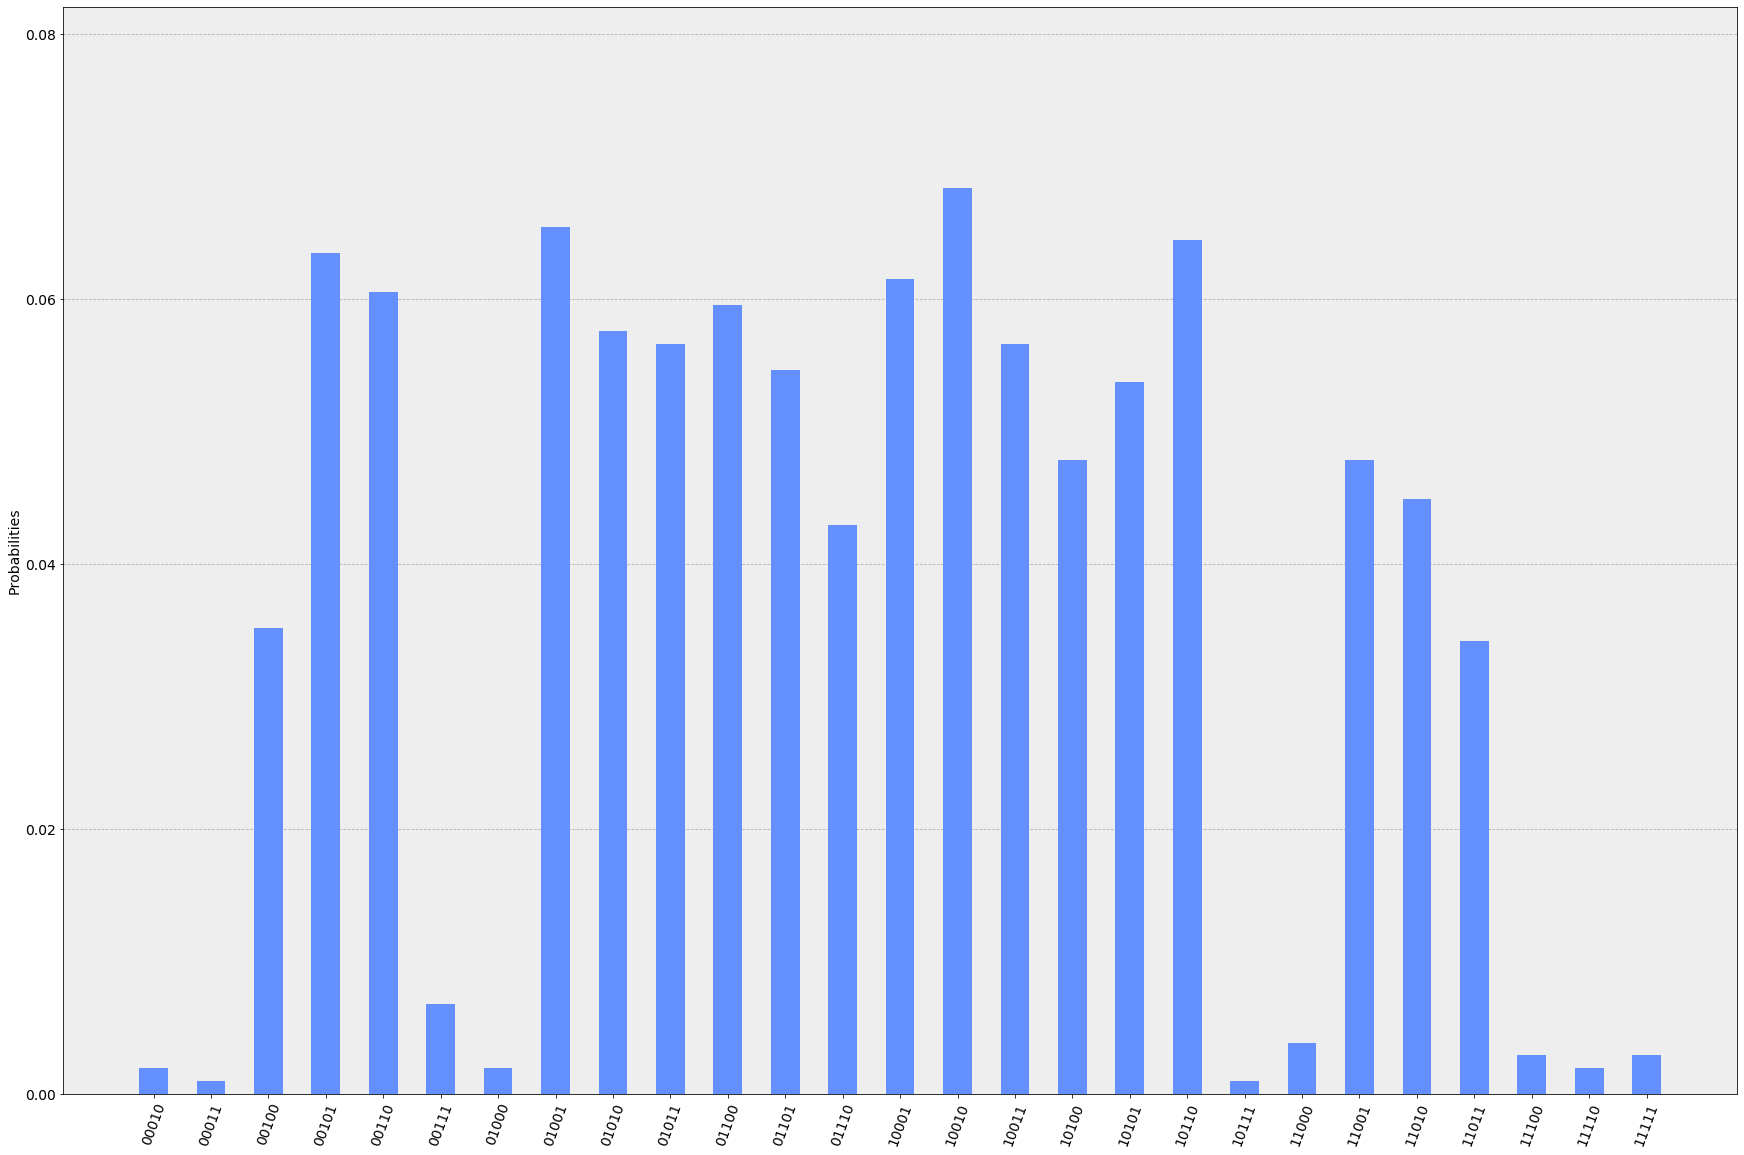

In [11]:
from qiskit.visualization import plot_histogram
plot_histogram(res.get_counts(),figsize = (30,20),bar_labels = False)

In [12]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        
        C = C + w*x[e2]*(1-x[e1])
        
    return C


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 14.61 while the true value is - 

The approximate solution is x* = 00101 with C(x*) = 25 

The cost function is distributed as: 



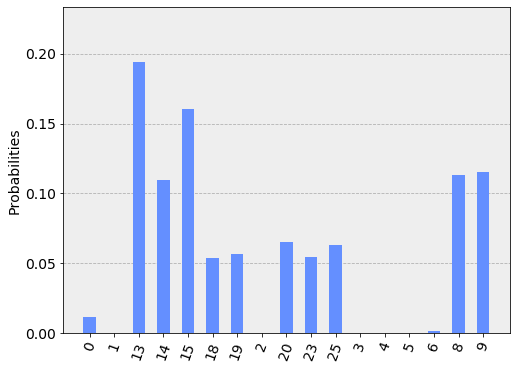

In [13]:
# Evaluate the data from the simulator
counts = res.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is - \n' % (M1_sampled))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

## Directed Weighted MAX-CUT:

### The Objective function for undirected MAX-CUT is defined as  $\neg x_1 $ & $ x_2$ , meaning only edges leaving the set of vertices in set "0" -> "1" are included into the expectation value. However the user only need to specify that the edges are directed when instantiating the max_cut package:

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


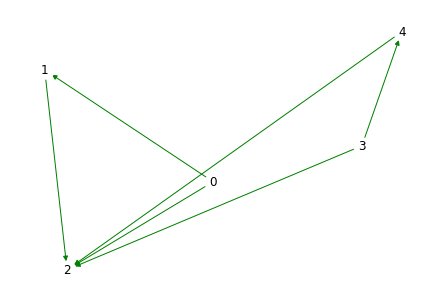

In [14]:
G = nx.DiGraph()
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,6.0),(0,2,7.0),(1,2,8.0),(3,2,9.0),(3,4,10.0),(4,2,4.0)] 

G.add_nodes_from(V)
G.add_weighted_edges_from(E)


nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

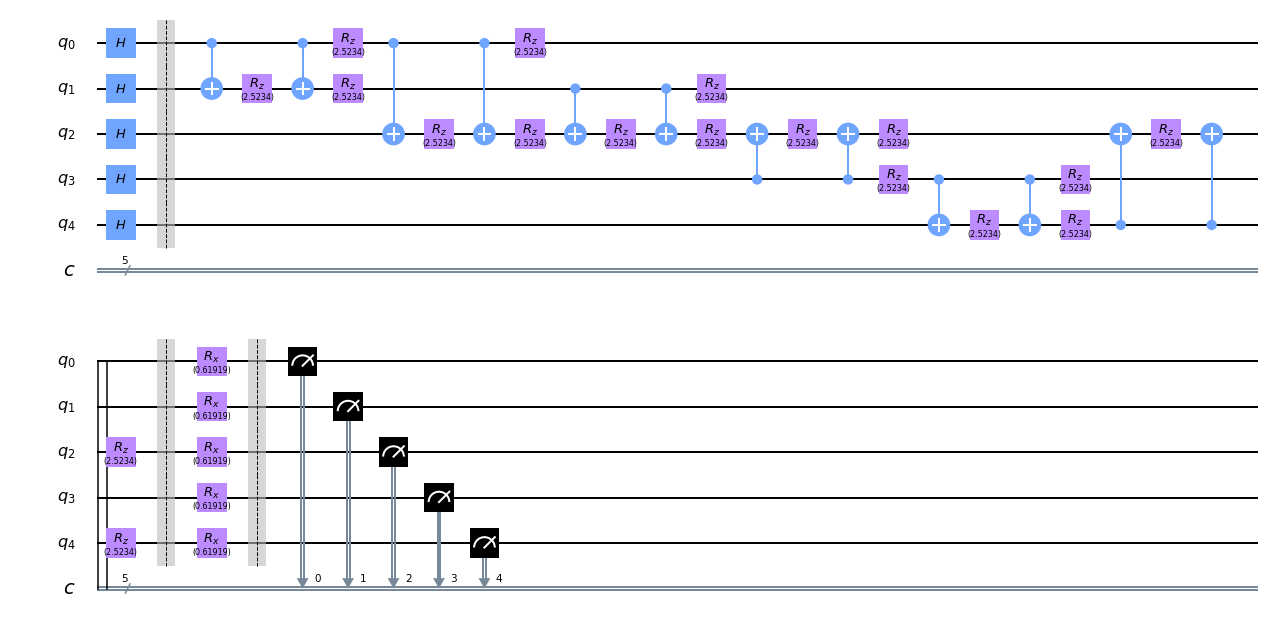

In [15]:
# instantiate a MAX_CUT object which prepares converts the objective function into a pauli hamiltonian
shots = 1024
max_cutWeights = mc.max_cut(G,shots=shots,directed=True)
max_cutWeights.generate_quantumCircuit(G, hyperparams)

In [16]:
hyperparams =[4.06348494, 0.89229044]
opt_hyperparams = max_cutWeights.run_QAOA(hyperparams,'COBYLA')

     fun: -13.3203125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 19
  status: 1
 success: True
       x: array([3.93870282, 0.87769577])


In [17]:
max_cutWeights.generate_quantumCircuit(G, opt_hyperparams)
res = max_cutWeights.run_circuit(G)

backend setup: Complete running circuit
Simulation: Complete!
Expectation Value : 13.5390625


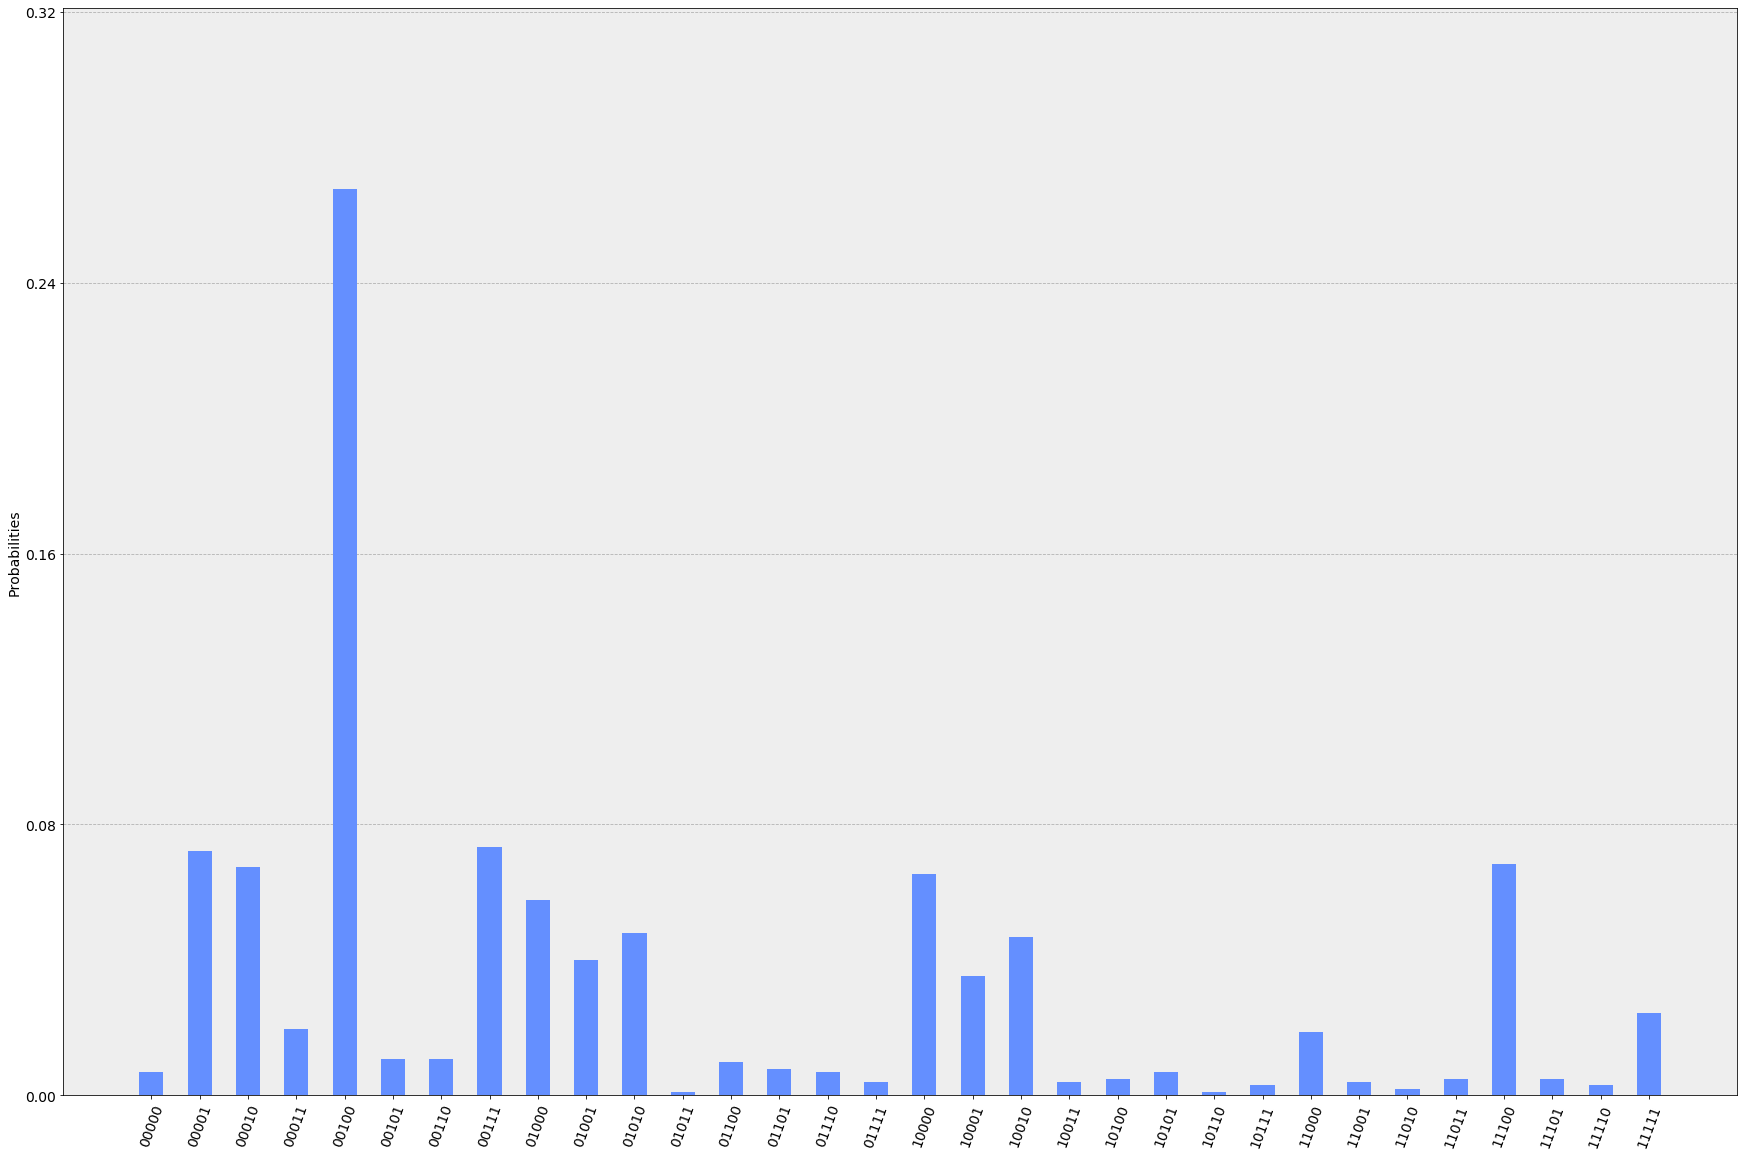

In [18]:
plot_histogram(res.get_counts(),figsize = (30,20),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 13.54 while the true value is - 

The approximate solution is x* = 00101 with C(x*) = 34 

The cost function is distributed as: 



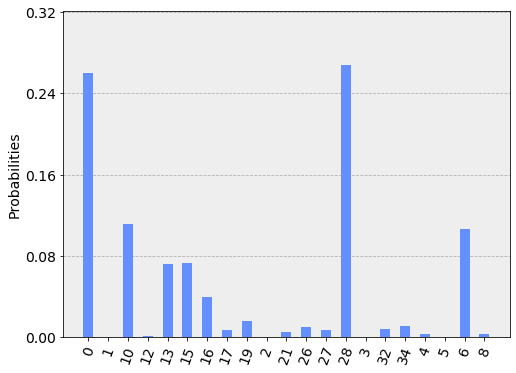

In [19]:
# TODO: add this function into the expectation value package to provide users with better understanding 
# of the results obtained 

# Evaluate the data from the simulator
counts = res.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is - \n' % (M1_sampled))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)